In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, merge, subtract
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, GlobalAvgPool2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2

import tensorflow as tf
import os
import tensorflow_datasets as tfds

import numpy as np
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Prepare Dataset

In [0]:
!ls
!unzip "/content/drive/My Drive/inputs.zip"

drive  inputs  __MACOSX  sample_data
Archive:  /content/drive/My Drive/inputs.zip
replace __MACOSX/._inputs? [y]es, [n]o, [A]ll, [N]one, [r]ename: yA
  inflating: __MACOSX/._inputs       
replace inputs/almac12.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: t
error:  invalid response [t]
replace inputs/almac12.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: inputs/almac12.jpg      
replace __MACOSX/inputs/._almac12.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/inputs/._almac12.jpg  
  inflating: inputs/db6.jpg          
  inflating: __MACOSX/inputs/._db6.jpg  
  inflating: inputs/almac1.jpg       
  inflating: __MACOSX/inputs/._almac1.jpg  
  inflating: inputs/ryton2.jpg       
  inflating: __MACOSX/inputs/._ryton2.jpg  
  inflating: inputs/database.txt     
  inflating: __MACOSX/inputs/._database.txt  
  inflating: inputs/ryton3.jpg       
  inflating: __MACOSX/inputs/._ryton3.jpg  
  inflating: inputs/db7.jpg          
  inflating: __MACOSX/inputs/._db7.jpg

In [0]:
INPUT_SIZE = (244,244)
def load_image(filename):
  fp = open(filename, 'r')
  lines = fp.read().splitlines()
  imgs = []
  for img_path in lines:
    # img = tf.keras.preprocessing.image.load_img(img_path)
    # img = tf.keras.preprocessing.image.img_to_array(img)
    # img = tf.image.resize(img, INPUT_SIZE)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, INPUT_SIZE)
    b, g, r = cv2.split(img)
    img2 = cv2.merge([r,g,b]) 
    imgs.append(img2)
  return np.array(imgs)

In [0]:
database = load_image('/content/inputs/database.txt')
img1 = load_image('/content/inputs/anchor.txt')

In [0]:
# alexander_mcqueen
# asics-gel-kayano-5-og.jpg
# daybreak.jpg
# gucci_rhyton.jpg
# ultraboost.jpg

pos_idx = [0]*13+[1]*10+[2]*9+[3]*12+[4]*10
positive = [database[idx] for idx in pos_idx]
positive = np.array(positive)

In [0]:
index = [1]*13+[0]*10+[0]*9+[0]*12+[0]*10 + [2]*13+[2]*10+[1]*9+[1]*12+[1]*10 + [3]*13+[3]*10+[3]*9+[2]*12+[2]*10\
          +[4]*13+[4]*10+[4]*9+[4]*12+[3]*10
negative = [database[idx] for idx in index]
negative = np.array(negative)

In [0]:
X_1 = np.concatenate((img1, img1, img1, img1, img1))
X_2 = np.concatenate((positive, negative))
Y_train = np.concatenate((np.ones(54), np.zeros(54*4)))

## Define Model & Training

In [0]:
def bn_model():
  input_1 = Input(shape=(244, 244, 3))
  input_2 = Input(shape=(244, 244, 3))

  vgg_16 = InceptionResNetV2(include_top = False,input_shape=(244,244,3))
  out = vgg_16.output
  out = Flatten()(out)
  out = Dense(4096,activation="relu",kernel_regularizer=l2(1e-3))(out)
  convnet = Model(vgg_16.input, out)  
  
  x1 = convnet(input_1)
  x2 = convnet(input_2)
  subtracted = subtract([x1, x2])
  L1_distance = Lambda(lambda x: K.abs(x))(subtracted)
  output = Dense(1, activation='relu')(L1_distance)

  model = Model([input_1, input_2], output)

  model.compile(loss='binary_crossentropy', optimizer=Adam(0.0006))

  model.summary()

  return model

In [0]:
model = bn_model()

In [0]:
callback = EarlyStopping(monitor='loss', patience=3)
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/backup/{epoch:02d}-{loss:.2f}',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [0]:
model.fit([X_1, X_2], Y_train, epochs=50, batch_size=32, callbacks=[callback, model_checkpoint_callback], workers=-1)

Epoch 1/50
270/270 [==============================] - 74s 272ms/step - loss: 3.6021
Epoch 2/50
270/270 [==============================] - 71s 262ms/step - loss: 3.5805
Epoch 3/50
270/270 [==============================] - 70s 260ms/step - loss: 3.5600
Epoch 4/50
270/270 [==============================] - 70s 260ms/step - loss: 3.5404
Epoch 5/50
270/270 [==============================] - 71s 263ms/step - loss: 3.5216
Epoch 6/50
 96/270 [=========>....................] - ETA: 45s - loss: 3.4769

In [0]:
model.load_weights('/content/drive/My Drive/backup/18-0.11')

KeyboardInterrupt: ignored

## Implementation deepranking model <br>
http://wangjiangb.github.io/pdfs/deep_ranking.pdf

In [0]:
def deepranking_convnet():

  # input image
  X = Input(shape=(244,244,3))
  
  # first convnet model - using vgg16
  vgg_out = vgg_16(X)
  vgg_out = Flatten()(vgg_out)
  vgg_out = Dropout(0.3)(vgg_out)
  vgg_out = Dense(4096)(vgg_out)
  vgg_out = Lambda(lambda x: K.l2_normalize(x, axis=1))(vgg_out)

  # second CNN
  x1 = AveragePooling2D((4,4))(X)
  x1 = Conv2D(96, kernel_size=(8,8), strides=(4,4), padding="same")(x1)
  x1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(x1)
  x1 = Flatten()(x1)
  x1 = Lambda(lambda x: K.l2_normalize(x, axis=1))(x1)

  # third CNN
  x2 = AveragePooling2D((8,8))(X)
  x2 = Conv2D(96, kernel_size=(8,8), strides=(4,4), padding="same")(x2)
  x2 = MaxPooling2D(pool_size=(7,7),strides=(4,4))(x2)
  x2 = Flatten()(x2)
  x2 = Lambda(lambda x: K.l2_normalize(x, axis=1))(x2)

  merge_1 = concatenate([x1, x2])
  merge_2 = concatenate([merge_1, vgg_out])
  
  embedding = Dense(4096)(merge_2)
  l2_norm_final = Lambda(lambda x: K.l2_normalize(x, axis=1))(embedding)

  final_model = Model(inputs=X, outputs=l2_norm_final)
  return final_model


In [0]:
def deepranking_model():
  anchor = Input(shape=(244,244,3))
  postivie = Input(shape=(244,244,3))
  negative = Input(shape=(244,244,3))

  dr_convnet = deepranking_convnet()

  a_enc = dr_convnet(anchor)
  p_enc = dr_convnet(postivie)
  n_enc = dr_convnet(negative)
  model = Model(inputs=[anchor, postivie, negative], outputs=[a_enc, p_enc, n_enc])
  return model

In [0]:
model = deepranking_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 4096)         153958400   input_11[0][0]                   
                                                                 input_12[0][0]             

## Test


In [0]:
pred = model.predict([X_1, X_2])

In [0]:
X_test = X_1[30].reshape(1, 244, 244, 3)
X_test = np.repeat(X_test, 5, axis=0)

In [0]:
model.predict([X_test, database])

array([[0.42942765],
       [0.6068171 ],
       [0.647137  ],
       [0.48321474],
       [0.66874725]], dtype=float32)

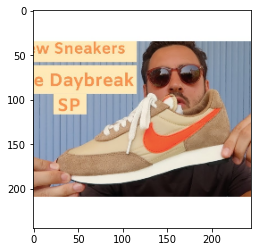

In [0]:
plt.imshow(X_1[30])

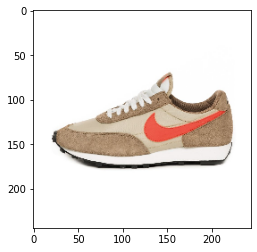

In [0]:
plt.imshow(database[2])